In [1]:
imagePath = "T_Sheep_BaseColor.tga"

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image = Image.open(imagePath)

In [150]:
def color(h,s,v):
    return np.array([h * (255 / 360), s * (255 / 100), v * (255 / 100)], dtype="uint8")

baseColor = color(30, 86, 40)

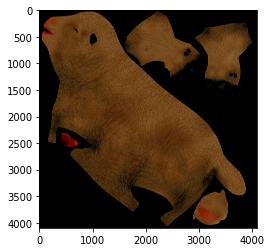

In [182]:
alpha = np.asarray(image)[:,:,3]
hsv = np.asarray(image.convert("HSV"), dtype="int32")

hue = hsv[:,:,0]
saturation = hsv[:,:,1]
value = hsv[:,:,2]

furCondition = np.logical_and.reduce([alpha > 0, saturation < 128, value > 96])

meanHue = hue.mean(where=furCondition)
meanSaturation = saturation.mean(where=furCondition)
meanValue = value.mean(where=furCondition)

valueMask = 1 - np.abs(value - meanValue) / meanValue

inputColor = np.array([meanHue, meanSaturation, meanValue])


hueShift = int(baseColor[0] - inputColor[0])
saturationShift = np.array(valueMask * (baseColor[1] - inputColor[1]), dtype="int32")
valueShift = int(baseColor[2] - inputColor[2])

hsv[:,:,0] += hueShift
hsv[:,:,1] += saturationShift
hsv[:,:,2] += valueShift

hsv = np.array(hsv.clip(0,255), dtype="uint8")

red = np.array([0,255,255])

output = Image.fromarray(hsv, "HSV").convert("RGB")
a = Image.fromarray(alpha, "L")
#output.putalpha(a)

plt.imshow(output)

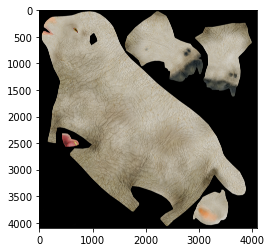

In [174]:
plt.imshow(image.convert("RGB"))